<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Final_notebooks/Load_Profile_DSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Profile Demand Side Response

**Goal:**
- To take the load profile data and make the required adjustments to simulate demand side response

0. Import the modules

In [ ]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Import the data

In [ ]:
# import data
# load_profile = pd.read_csv("../data/load_example.csv", usecols=[1]).values
load_profile = pd.read_csv("https://bitbucket.org/scotwheeler/oxemf_3yp/raw/5d950da31a156418c8abfa1dd86668688715e98e/data/load_example.csv", usecols=[1]).values

In [ ]:
np.shape(load_profile)

(17520, 1)

In [ ]:
# to process the data, it really ought to be a in a DataFrame with a date column attached to it
# we need to create a list of dates and times to span the whole year in 30 minute periods
year = '2018'
dti = pd.date_range(year + '-01-01', periods=17520, freq="0.5H")

# note that this list of times starts at Jan 1st 00:00:00. If we want to start at 00:30:00, then do the following:
# 1. Change the periods to 17521
# 2. dti = dti[1:] to remove the 00:00:00 entry

In [ ]:
# put all this data into a dataframe
load_profile_df = pd.DataFrame(dti, columns=['Date_Time'])
load_profile_df['Demand (kWh)'] = load_profile
load_profile_df['Date'] = [d.date() for d in load_profile_df['Date_Time']]      # separating it into separate date and time columns to make it easier to form a mask later on
load_profile_df['Time'] = [d.time() for d in load_profile_df['Date_Time']]

In [ ]:
load_profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date_Time     17520 non-null  datetime64[ns]
 1   Demand (kWh)  17520 non-null  float64       
 2   Date          17520 non-null  object        
 3   Time          17520 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 547.6+ KB


2. Split into Seasonal DataFrames

In [ ]:
# Define the start and end dates for each of the seasons and then define the masks
# format of mask: YYYY-MM-DD

# winter
winter_pt_1_start = pd.to_datetime(year + '-01-01')
winter_pt_1_end = pd.to_datetime(year + '-02-28')
winter_pt_2_start = pd.to_datetime(year + '-12-01')
winter_pt_2_end = pd.to_datetime(year + '-12-31')

winter_pt1_mask = (load_profile_df['Date_Time'] >= winter_pt_1_start) & (load_profile_df['Date_Time'] <= winter_pt_1_end)
winter_pt2_mask = (load_profile_df['Date_Time'] >= winter_pt_2_start) & (load_profile_df['Date_Time'] <= winter_pt_2_end)

# spring
spring_start = pd.to_datetime(year + '-03-01')
spring_end = pd.to_datetime(year + '-05-31')

spring_mask = (load_profile_df['Date_Time'] >= spring_start) & (load_profile_df['Date_Time'] <= spring_end)

# summer
summer_start = pd.to_datetime(year + '-06-01')
summer_end = pd.to_datetime(year + '-08-31')

summer_mask = (load_profile_df['Date_Time'] >= summer_start) & (load_profile_df['Date_Time'] <= summer_end)

# autumn
autumn_start = pd.to_datetime(year + '-09-01')
autumn_end = pd.to_datetime(year + '-11-30')

autumn_mask = (load_profile_df['Date_Time'] >= autumn_start) & (load_profile_df['Date_Time'] <= autumn_end)

In [ ]:
# extract each of the dataframes

# winter_pt_1 
winter1_df = load_profile_df.loc[winter_pt1_mask]

# winter_pt_2 
winter2_df = load_profile_df.loc[winter_pt2_mask]

winter_combined_df = pd.concat([winter1_df, winter2_df])    # combine the two DataFrames from winter
winter_combined_df.reset_index(inplace = True, drop = True)

# spring
spring_df = load_profile_df.loc[spring_mask]

# summer
summer_df = load_profile_df.loc[summer_mask]

# autumn
autumn_df = load_profile_df.loc[autumn_mask]

In [ ]:
len(winter1_df), len(winter2_df), len(spring_df), len(summer_df), len(autumn_df)

(2785, 1441, 4369, 4369, 4321)

3.  Define the functions to edit the demand profile

3.1 Import the data to edit the demand profile

In [ ]:
dsr_edit_data = pd.read_csv('/content/drive/MyDrive/3YP/data/demand_response_final/3yp_dsr_data_test.csv')
dsr_edit_data['autumn_bottom_25_low'] = pd.to_numeric(dsr_edit_data['autumn_bottom_25_low'], errors='coerce')
dsr_edit_data = dsr_edit_data.fillna(0)[:-1]

In [ ]:
dsr_edit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   30 Minute Time Period         48 non-null     float64
 1   winter_top_25_low             48 non-null     float64
 2   winter_top_25_medium_low      48 non-null     float64
 3   winter_top_25_medium_high     48 non-null     float64
 4   winter_top_25_high            48 non-null     float64
 5   winter_bottom_25_low          48 non-null     float64
 6   winter_bottom_25_medium_low   48 non-null     float64
 7   winter_bottom_25_medium_high  48 non-null     float64
 8   winter_bottom_25_high         48 non-null     float64
 9   spring_top_25_low             48 non-null     float64
 10  spring_top_25_medium_low      48 non-null     float64
 11  spring_top_25_medium_high     48 non-null     float64
 12  spring_top_25_high            48 non-null     float64
 13  spring_

Define a function that takes the demand side response data and combines the columns to form one column for each season, engagement level

In [ ]:
def dsr_season_combine(dsr_data):

  # factors
  top_factor = 0
  bottom_factor = 0

  # We will do this individually just in case any seasons want to use any different interpolation values
  # spring
  dsr_data['spring_top_25'] = dsr_data['spring_top_25_low'] + dsr_data['spring_top_25_high'] + top_factor*(dsr_data['spring_top_25_medium_low'] + dsr_data['spring_top_25_medium_low'])
  dsr_data['spring_bottom_25'] = dsr_data['spring_bottom_25_low'] + dsr_data['spring_bottom_25_high'] + bottom_factor*(dsr_data['spring_bottom_25_medium_low'] + dsr_data['spring_bottom_25_medium_low'])

  # summer
  dsr_data['summer_top_25'] = dsr_data['summer_top_25_low'] + dsr_data['summer_top_25_high'] + top_factor*(dsr_data['summer_top_25_medium_low'] + dsr_data['summer_top_25_medium_low'])
  dsr_data['summer_bottom_25'] = dsr_data['summer_bottom_25_low'] + dsr_data['summer_bottom_25_high'] + bottom_factor*(dsr_data['summer_bottom_25_medium_low'] + dsr_data['summer_bottom_25_medium_low'])

  # autumn
  dsr_data['autumn_top_25'] = dsr_data['autumn_top_25_low'] + dsr_data['autumn_top_25_high'] + top_factor*(dsr_data['autumn_top_25_medium_low'] + dsr_data['autumn_top_25_medium_low'])
  dsr_data['autumn_bottom_25'] = dsr_data['autumn_bottom_25_low'] + dsr_data['autumn_bottom_25_high'] + bottom_factor*(dsr_data['autumn_bottom_25_medium_low'] + dsr_data['autumn_bottom_25_medium_low'])
 
  # winter
  dsr_data['winter_top_25'] = dsr_data['winter_top_25_low'] + dsr_data['winter_top_25_high'] + top_factor*(dsr_data['winter_top_25_medium_low'] + dsr_data['winter_top_25_medium_low'])
  dsr_data['winter_bottom_25'] = dsr_data['winter_bottom_25_low'] + dsr_data['winter_bottom_25_high'] + bottom_factor*(dsr_data['winter_bottom_25_medium_low'] + dsr_data['winter_bottom_25_medium_low'])
 
  # converting the units from kW to kWh
  dsr_data['spring_top_25'] = dsr_data['spring_top_25'] * 0.5                   
  dsr_data['spring_bottom_25'] = dsr_data['spring_bottom_25'] * 0.5             
  dsr_data['summer_top_25'] = dsr_data['summer_top_25'] * 0.5
  dsr_data['summer_bottom_25'] = dsr_data['summer_bottom_25'] * 0.5
  dsr_data['autumn_top_25'] = dsr_data['autumn_top_25'] * 0.5
  dsr_data['autumn_bottom_25'] = dsr_data['autumn_bottom_25'] * 0.5
  dsr_data['winter_top_25'] = dsr_data['winter_top_25'] * 0.5
  dsr_data['winter_bottom_25'] = dsr_data['winter_bottom_25'] * 0.5

  return dsr_data

In [ ]:
dsr_edit_data = dsr_season_combine(dsr_edit_data)

Define a function that edits the data and takes the inputs:
- Season
- Level of Performer

In [ ]:
''' 
inputs: 
- load_df                                                                       : (DataFrame)
- dsr_response_df     - contains the response data (kW)                         : (DataFrame)

- season              - what season is this dataframe                           : (string)
- engagement_level    - are they a 'top' OR 'bottom' performer                  : (string)

output:
- a new DataFrame
'''

" \ninputs: \n- load_df                                                                       : (DataFrame)\n- dsr_response_df     - contains the response data (kW)                         : (DataFrame)\n\n- season              - what season is this dataframe                           : (string)\n- engagement_level    - are they a 'top' OR 'bottom' performer                  : (string)\n\noutput:\n- a new DataFrame\n"

In [ ]:
def dsr_seaon_data_editor(load_df, dsr_edit_df, season, engagement_level):
  
  # 0. Make a copy of the load_df
  new_df = load_df
  new_df['ideal_demand_kWh'] = new_df['Demand (kWh)']
  
  # 1. Form the string of columns to extract
  # string is of the form [SEASON]_[ENGAGEMENT]_25
  core_column_string = str(season)+'_'+str(engagement_level)+'_25'

  # 2. Extract those column values
  dsr_response_values = dsr_edit_df[core_column_string].values

  # 3. Combine them with the current dataframe
  for i in range(len(load_df['Time'].unique())):
    #print(load_df['Time'].unique()[i]) #print(dsr_response_values[i])
    new_df.loc[new_df['Time'] == load_df['Time'].unique()[i], 'ideal_demand_kWh'] = dsr_response_values[i] + new_df.loc[new_df['Time'] == load_df['Time'].unique()[i], 'ideal_demand_kWh']

  # 5. Return the new dataframe
  return new_df

In [ ]:
shortened_summer_df = summer_df[:48]

In [ ]:
shortened_summer_df['Ideal_demand_kWh'] = shortened_summer_df['Demand (kWh)'] + dsr_edit_data['summer_top_25'].values
shortened_summer_df['Ideal_demand_kWh_bottom'] = shortened_summer_df['Demand (kWh)'] + dsr_edit_data['summer_bottom_25'].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 <a list of 8 Text major ticklabel objects>)

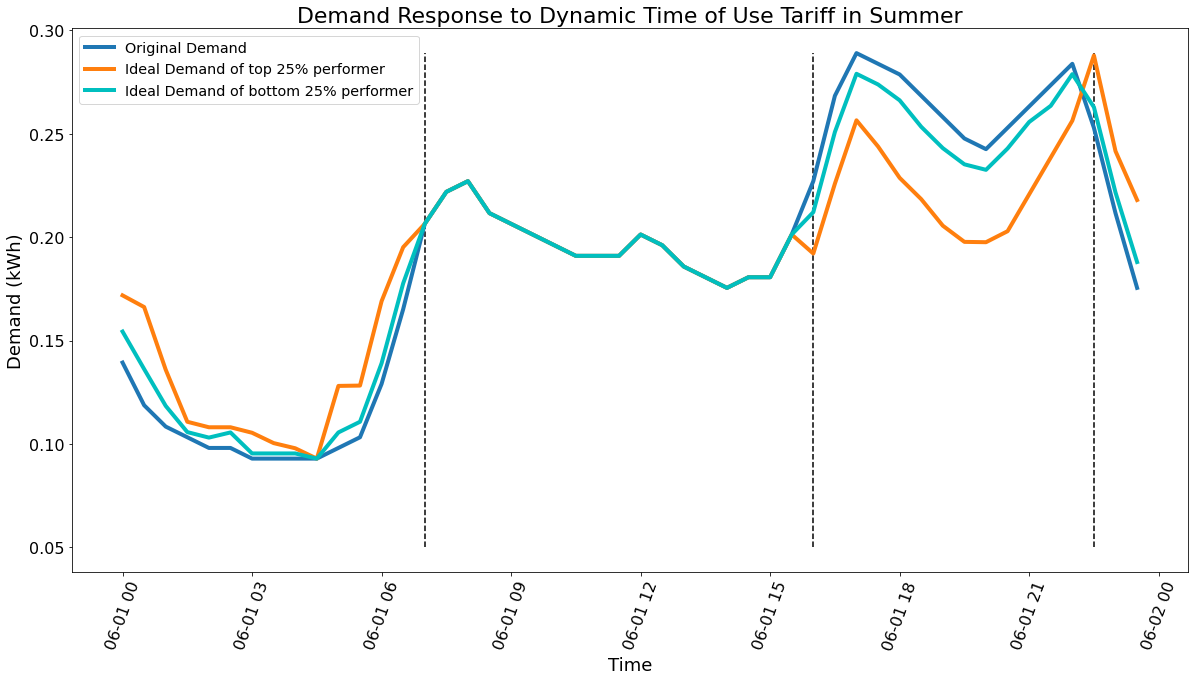

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(shortened_summer_df['Date_Time'], shortened_summer_df['Demand (kWh)'][0:48], label='Original Demand', linewidth=4)
plt.plot(shortened_summer_df['Date_Time'], shortened_summer_df['Ideal_demand_kWh'][0:48], label='Ideal Demand of top 25% performer', linewidth=4)
plt.plot(shortened_summer_df['Date_Time'], shortened_summer_df['Ideal_demand_kWh_bottom'][0:48], color = 'c', label='Ideal Demand of bottom 25% performer', linewidth=4)
plt.vlines(shortened_summer_df['Date_Time'].values[14], 0.05, max(shortened_summer_df['Demand (kWh)']), colors = 'k', linestyles='--')
plt.vlines(shortened_summer_df['Date_Time'].values[32], 0.05, max(shortened_summer_df['Demand (kWh)']), colors = 'k', linestyles='--')
plt.vlines(shortened_summer_df['Date_Time'].values[45], 0.05, max(shortened_summer_df['Demand (kWh)']), colors = 'k', linestyles='--')
plt.title('Demand Response to Dynamic Time of Use Tariff in Summer', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Demand (kWh)', fontsize=18)
plt.legend(loc = 0, fontsize='x-large')
plt.xticks(rotation = 70, fontsize=16)
plt.yticks(fontsize=16)

In [ ]:
print(sum(shortened_summer_df['Demand (kWh)'][0:48]), sum(shortened_summer_df['Ideal_demand_kWh'][0:48]))

9.15525549791455 8.995255497914552


In [ ]:
new_summer_df = dsr_seaon_data_editor(spring_df, dsr_edit_data, season='summer', engagement_level='top')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


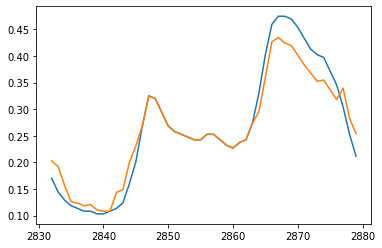

In [ ]:
plt.plot(new_summer_df['Demand (kWh)'][0:48])
plt.plot(new_summer_df['ideal_demand_kWh'][0:48])

We need to define a set of functions that:
1. Subtract energy usage from the high price times
2. Add usage to the low price times

We will first make the functions for the top 25% of performers

In [ ]:
''' 
inputs: 
- df                                                                            : (DataFrame)

- high_start_time     - start time of high price period                         : (datetime)
- high_end_time       - end time of high price period                           : (datetime)
- high_price_subtract - how much to subtract from high price period             : (float)

- low_start_time      - start time of low price period                          : (datetime)
- low_end_time        - end time of low price period                            : (datetime)
- low_price_add       - how much energy (kWh) to add to low price period        : (float)

output:
- a new DataFrame
'''

' \ninputs: \n- df                                                                            : (DataFrame)\n\n- high_start_time     - start time of high price period                         : (datetime)\n- high_end_time       - end time of high price period                           : (datetime)\n- high_price_subtract - how much to subtract from high price period             : (float)\n\n- low_start_time      - start time of low price period                          : (datetime)\n- low_end_time        - end time of low price period                            : (datetime)\n- low_price_add       - how much energy (kWh) to add to low price period        : (float)\n\noutput:\n- a new DataFrame\n'

In [ ]:
def seasonal_low_high(df, high_start_time, high_end_time, high_price_subtract, low_start_time, low_end_time, low_price_add):

  # define the high price mask
  high_mask = (df['Time'] >= high_start_time) & (df['Time'] <= high_end_time)

  # define the low price mask
  low_mask = (df['Time'] >= low_start_time) & (df['Time'] <= low_end_time)

  # subtract the energy from the high price period
  df['high'] = (df['Demand (kWh)'].loc[high_mask] * 0) - high_price_subtract
  df['high'].fillna(0, inplace = True)

  # add the energy to the low price period
  df['low'] = (df['Demand (kWh)'].loc[low_mask] * 0) + low_price_add
  df['low'].fillna(0, inplace = True)

  # calculate the new column
  df['Ideal Demand (kWh)'] = df['Demand (kWh)'] + df['high'] + df['low']

  return df

4. Define the Variables for 25% and 75% households for all the seasons


# Extra for now

4.1 Spring

In [ ]:
# TOP 25%

# define the high price time
high_price_start_time_high_25_spring = datetime(year = int(year), month = 6, day = 5, hour=5, minute=30).time()
high_price_end_time_high_25_spring = datetime(year = int(year), month = 6, day = 5, hour=9, minute=30).time()

high_price_subtract_high_25_spring = 2  # define how much we are removing during the high price 

# define the low price time
low_price_start_time_high_25_spring = datetime(year = int(year), month = 6, day = 5, hour=1, minute=30).time()
low_price_end_time_high_25_spring = datetime(year = int(year), month = 6, day = 5, hour=5, minute=29).time()

low_price_add_high_25_spring = 0.4  # define how much we are adding during the low price 

In [ ]:
# BOTTOM 25%

# define the high price time
high_price_start_time_low_25_spring = datetime(year = int(year), month = 6, day = 5, hour=5, minute=30).time()
high_price_end_time_low_25_spring = datetime(year = int(year), month = 6, day = 5, hour=9, minute=30).time()

high_price_subtract_low_25_spring = ___  # define how much we are removing during the high price 

# define the low price time
low_price_start_time_low_25_spring = datetime(year = int(year), month = 6, day = 5, hour=1, minute=30).time()
low_price_end_time_low_25_spring = datetime(year = int(year), month = 6, day = 5, hour=5, minute=29).time()

low_price_add_low_25_spring = ___  # define how much we are adding during the low price 

4.2 Summer

In [ ]:
# TOP 25%

# define the high price time
high_price_start_time_top_25_summer = datetime(year = int(year), month = 6, day = 5, hour=12, minute=30).time()
high_price_end_time_top_25_summer = datetime(year = int(year), month = 6, day = 5, hour=20, minute=30).time()

high_price_subtract_top_25_summer = 0.05  # define how much we are removing during the high price 

# define the low price time
low_price_start_time_top_25_summer = datetime(year = int(year), month = 6, day = 5, hour=1, minute=30).time()
low_price_end_time_top_25_summer = datetime(year = int(year), month = 6, day = 5, hour=5, minute=29).time()

low_price_add_top_25_summer = 0.05  # define how much we are adding during the low price 

In [ ]:
summer_top_25_df = seasonal_low_high(summer_df, high_price_start_time_top_25_summer, high_price_end_time_top_25_summer, high_price_subtract_top_25_summer, 
                                     low_price_start_time_top_25_summer, low_price_end_time_top_25_summer, low_price_add_top_25_summer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

(array([736846.   , 736846.125, 736846.25 , 736846.375, 736846.5  ,
        736846.625, 736846.75 , 736846.875, 736847.   ]),
 <a list of 9 Text major ticklabel objects>)

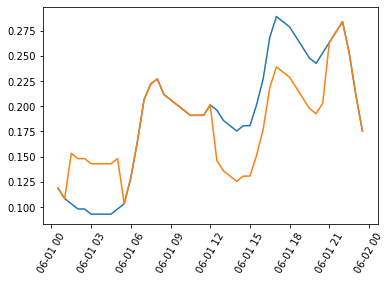

In [ ]:
n_start = 1
n_end = 48

plt.plot(summer_top_25_df['Date_Time'][n_start:n_end], summer_top_25_df['Demand (kWh)'][n_start:n_end])
plt.plot(summer_top_25_df['Date_Time'][n_start:n_end], summer_top_25_df['Ideal Demand (kWh)'][n_start:n_end])
plt.xticks(rotation = 60)

In [ ]:
# BOTTOM 25%

# define the high price time
high_price_start_time_low_25_summer = datetime(year = int(year), month = 6, day = 5, hour=5, minute=30).time()
high_price_end_time_low_25_summer = datetime(year = int(year), month = 6, day = 5, hour=9, minute=30).time()

high_price_subtract_low_25_summer = ___  # define how much we are removing during the high price 

# define the low price time
low_price_start_time_low_25_summer = datetime(year = int(year), month = 6, day = 5, hour=1, minute=30).time()
low_price_end_time_low_25_summer = datetime(year = int(year), month = 6, day = 5, hour=5, minute=29).time()

low_price_add_low_25_summer = ___  # define how much we are adding during the low price 

4.3 Autumn

In [ ]:
# TOP 25%

# define the high price time
high_price_start_time_top_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=5, minute=30).time()
high_price_end_time_top_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=9, minute=30).time()

high_price_subtract_top_25_autumn = ___  # define how much we are removing during the high price 

# define the low price time
low_price_start_time_top_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=1, minute=30).time()
low_price_end_time_top_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=5, minute=29).time()

low_price_add_top_25_autumn = ___  # define how much we are adding during the low price 

In [ ]:
# BOTTOM 25%

# define the high price time
high_price_start_time_low_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=5, minute=30).time()
high_price_end_time_low_25_autumn= datetime(year = int(year), month = 6, day = 5, hour=9, minute=30).time()

high_price_subtract_low_25_autumn = ___  # define how much we are removing during the high price 

# define the low price time
low_price_start_time_low_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=1, minute=30).time()
low_price_end_time_low_25_autumn = datetime(year = int(year), month = 6, day = 5, hour=5, minute=29).time()

low_price_add_low_25_autumn = ___  # define how much we are adding during the low price 

SyntaxError: ignored

4.4 Winter

5. Concatenate all the dataframes together to form an annual demand profile